
--- Horizonte: 24 horas ---
MAE:  991.78 MW
RMSE: 1182.42 MW
MAPE: 4.70 %


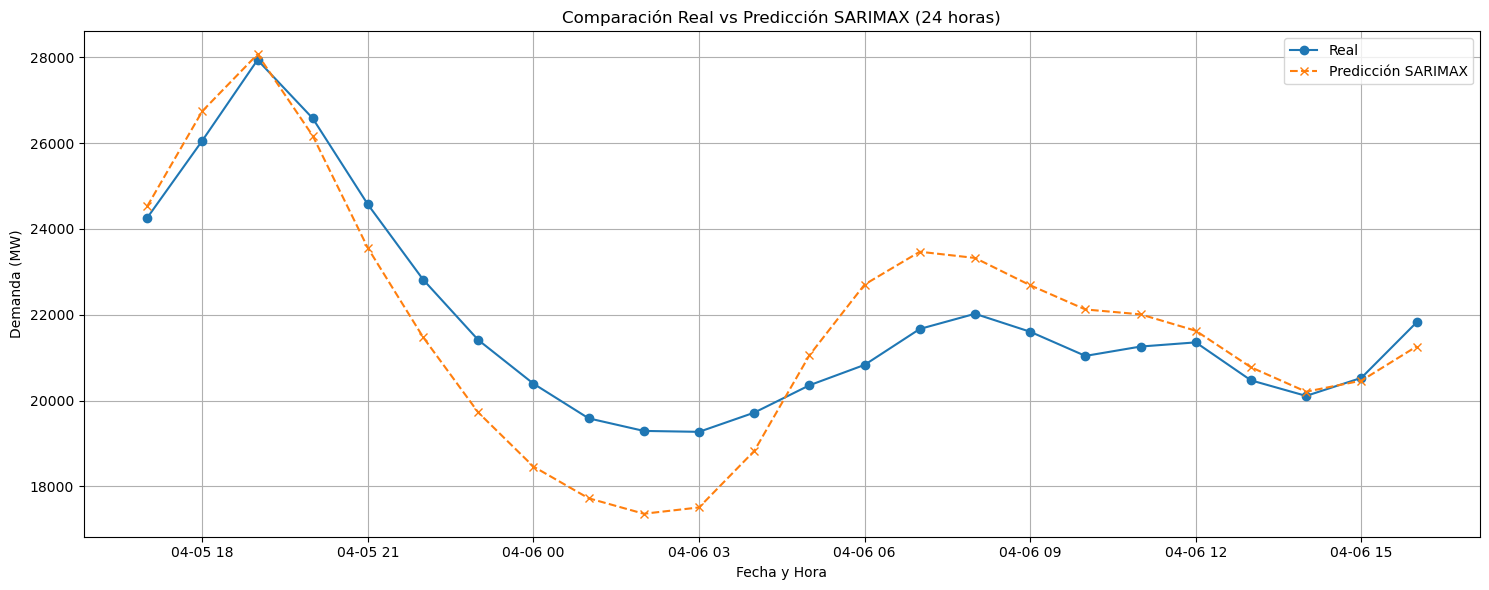

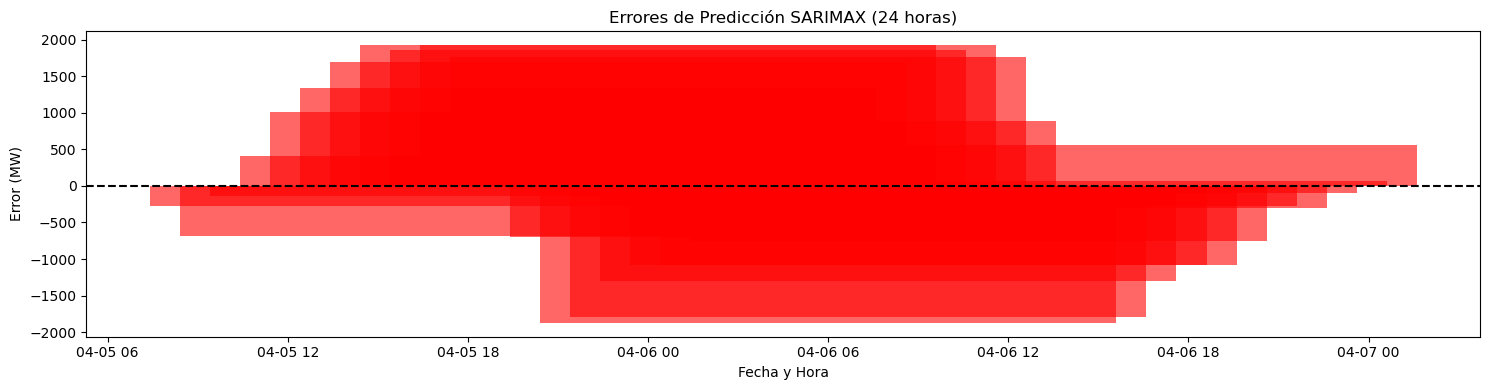


--- Horizonte: 72 horas ---
MAE:  3967.86 MW
RMSE: 4763.19 MW
MAPE: 15.89 %


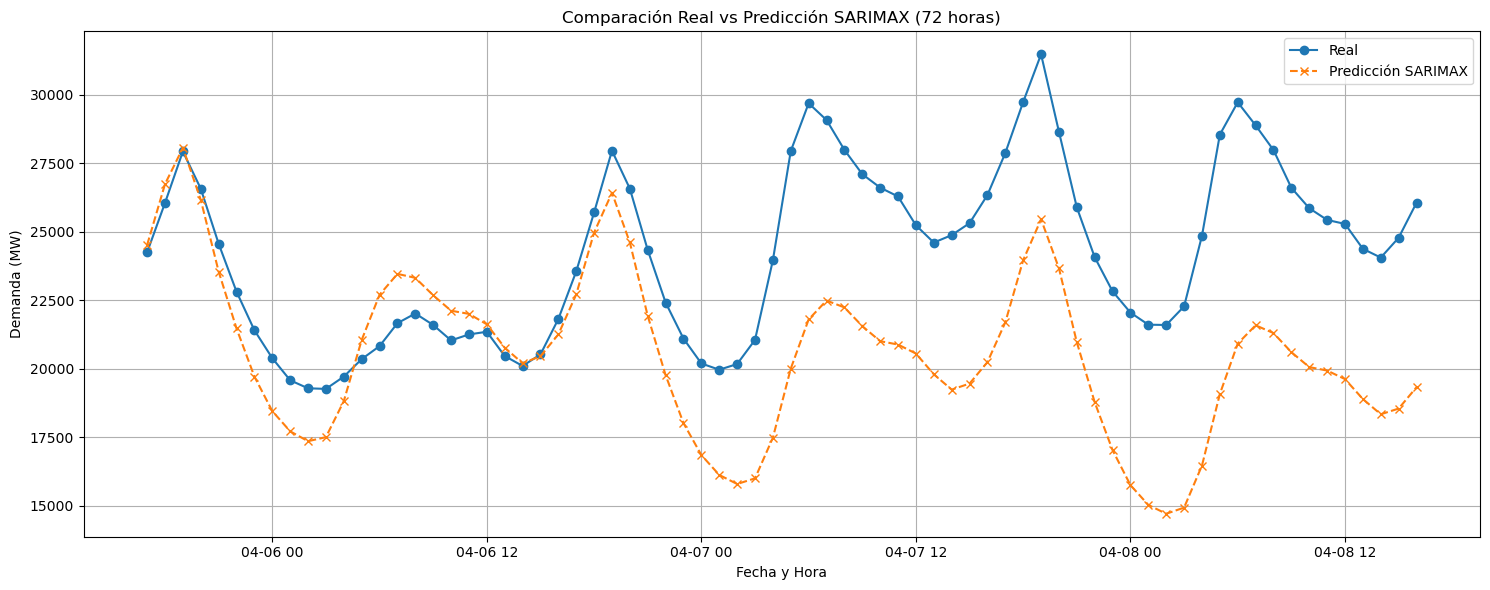

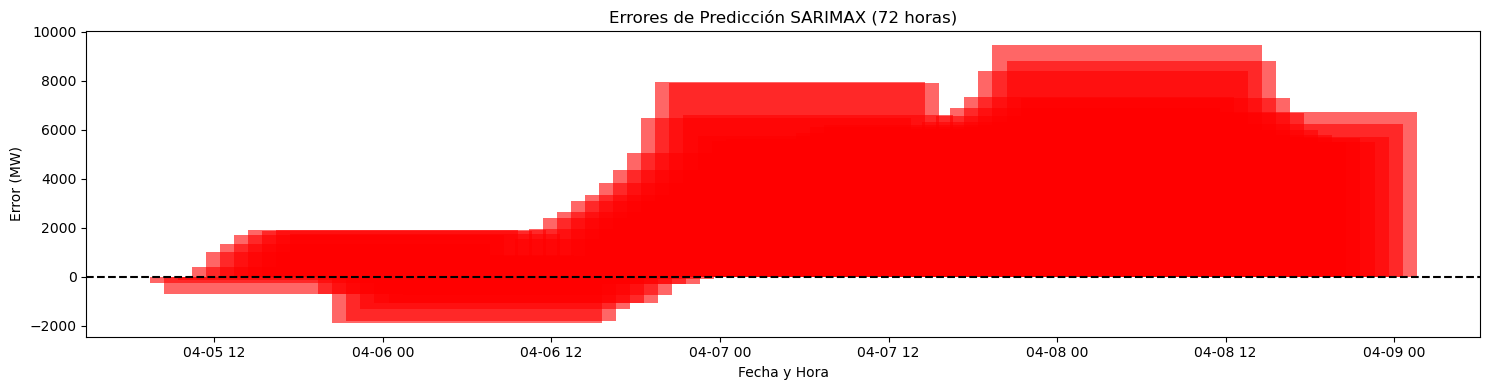


--- Horizonte: 168 horas ---
MAE:  6523.85 MW
RMSE: 7180.80 MW
MAPE: 25.72 %


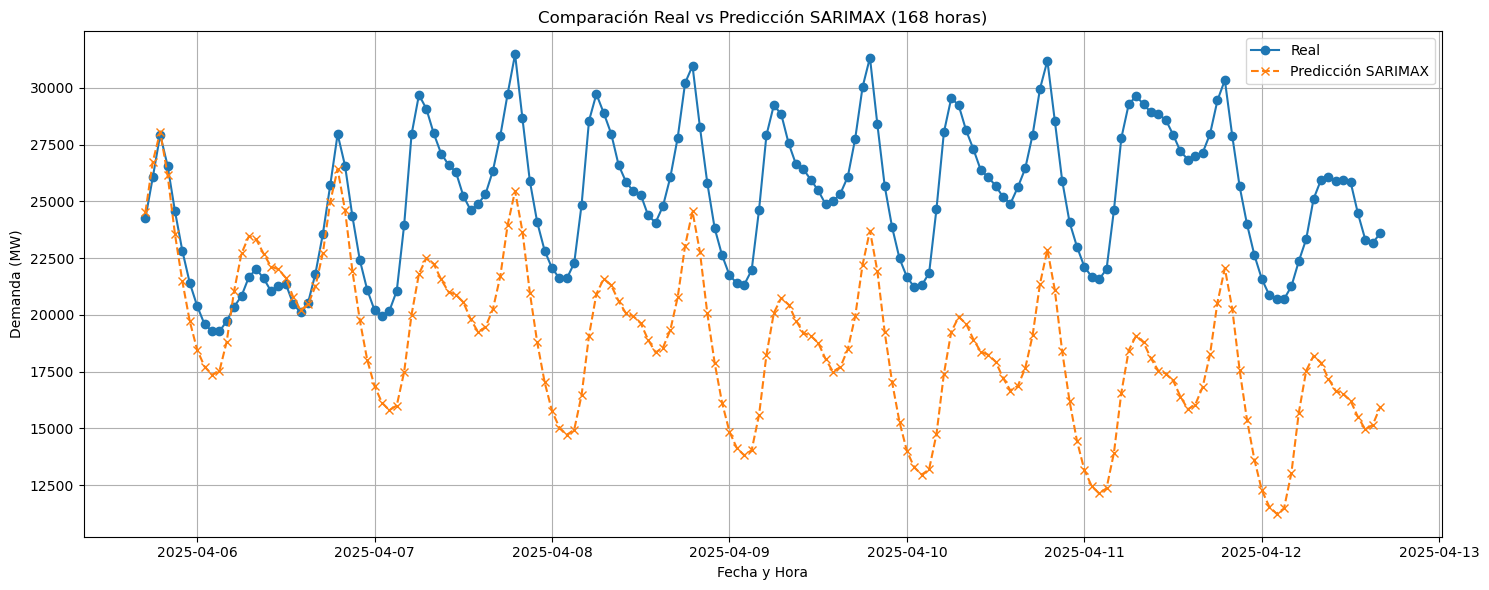

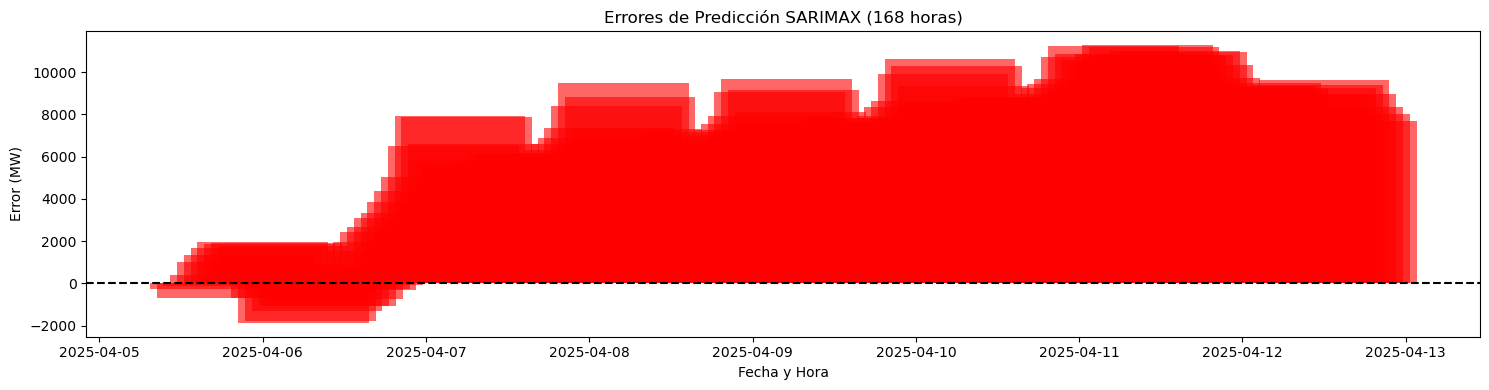


Resumen de métricas:
             MAE         RMSE       MAPE
24    991.779266  1182.422597   4.697539
72   3967.858719  4763.193700  15.889558
168  6523.847638  7180.800526  25.721427


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calcular_mape(y_real, y_pred):
    mask = y_real != 0
    return np.mean(np.abs((y_real[mask] - y_pred[mask]) / y_real[mask])) * 100

df = pd.read_excel('Unificado_def_2015_2025.xlsx')
df['datetime_utc'] = pd.to_datetime(df['datetime_utc']).dt.tz_localize(None)
df = df.set_index('datetime_utc')
df = df.drop(columns=['geo_id', 'geo_name'])
df = df.rename(columns={'value': 'demanda_mw'})

df_hora = df['demanda_mw'].resample('H').mean()

exog_hora = pd.DataFrame({
    'month': df_hora.index.month,
    'dayofweek': df_hora.index.dayofweek,
    'hour': df_hora.index.hour,
    'is_weekend': (df_hora.index.dayofweek >= 5).astype(int)
}, index=df_hora.index)


def evaluar_sarimax(train_hora, test_hora, exog_train, exog_test, horizonte_horas):
    modelo = SARIMAX(
        train_hora,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 24),
        exog=exog_train,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado = modelo.fit(disp=False)

    pred = resultado.predict(
        start=test_hora.index[0], end=test_hora.index[horizonte_horas-1], exog=exog_test.iloc[:horizonte_horas]
    )
    real = test_hora.iloc[:horizonte_horas]


    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    mape = calcular_mape(real, pred)

    print(f"\n--- Horizonte: {horizonte_horas} horas ---")
    print(f"MAE:  {mae:.2f} MW")
    print(f"RMSE: {rmse:.2f} MW")
    print(f"MAPE: {mape:.2f} %")


    plt.figure(figsize=(15, 6))
    plt.plot(real.index, real, label='Real', marker='o')
    plt.plot(pred.index, pred, label='Predicción SARIMAX', linestyle='--', marker='x')
    plt.title(f'Comparación Real vs Predicción SARIMAX ({horizonte_horas} horas)')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Demanda (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    errores = real - pred
    plt.figure(figsize=(15, 4))
    plt.bar(errores.index, errores, color='red', alpha=0.6)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Errores de Predicción SARIMAX ({horizonte_horas} horas)')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Error (MW)')
    plt.tight_layout()
    plt.show()

    return mae, rmse, mape


train_end_hora = df_hora.index[-1] - pd.Timedelta(days=7)
train_hora = df_hora.loc[:train_end_hora]
test_hora = df_hora.loc[train_end_hora + pd.Timedelta(hours=1):]
exog_train_hora = exog_hora.loc[train_hora.index]
exog_test_hora = exog_hora.loc[test_hora.index]


resultados = {}
for horizonte in [24, 72, 168]:
    mae, rmse, mape = evaluar_sarimax(
        train_hora, test_hora, exog_train_hora, exog_test_hora, horizonte
    )
    resultados[horizonte] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


print("\nResumen de métricas:")
print(pd.DataFrame(resultados).T)
